# Pan005 temp transects

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.lines as mlines

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42539/status,
Dashboard: /proxy/42539/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46825,Workers: 0
Dashboard: /proxy/42539/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38973,Total threads: 1
Dashboard: /proxy/41825/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42229,


In [4]:
# Import the data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[-120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [ ]:
def preprocess(ds):
    ds = ds[['thetao','so']].sel(yh=slice(-79,-62))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [ ]:
## Time slicing
# Taking last 5 years 
cont = cont.sel(time=slice('2006-01-01','2010-12-31'))
melt = melt.sel(time=slice('2006-01-01','2010-12-31'))

In [ ]:
tempC = cont['thetao']
tempM = melt['thetao']

In [ ]:
saltC = cont['so']
saltM = melt['so']

### The transects I will take:

I am wanting transects from different regimes, as per the Moorman paper.   
So, I am using:
- 135 W
- 170 W
- 260 W
- 70 E
<br>


Ruth's figure for reference (Moorman et al, 2020):  
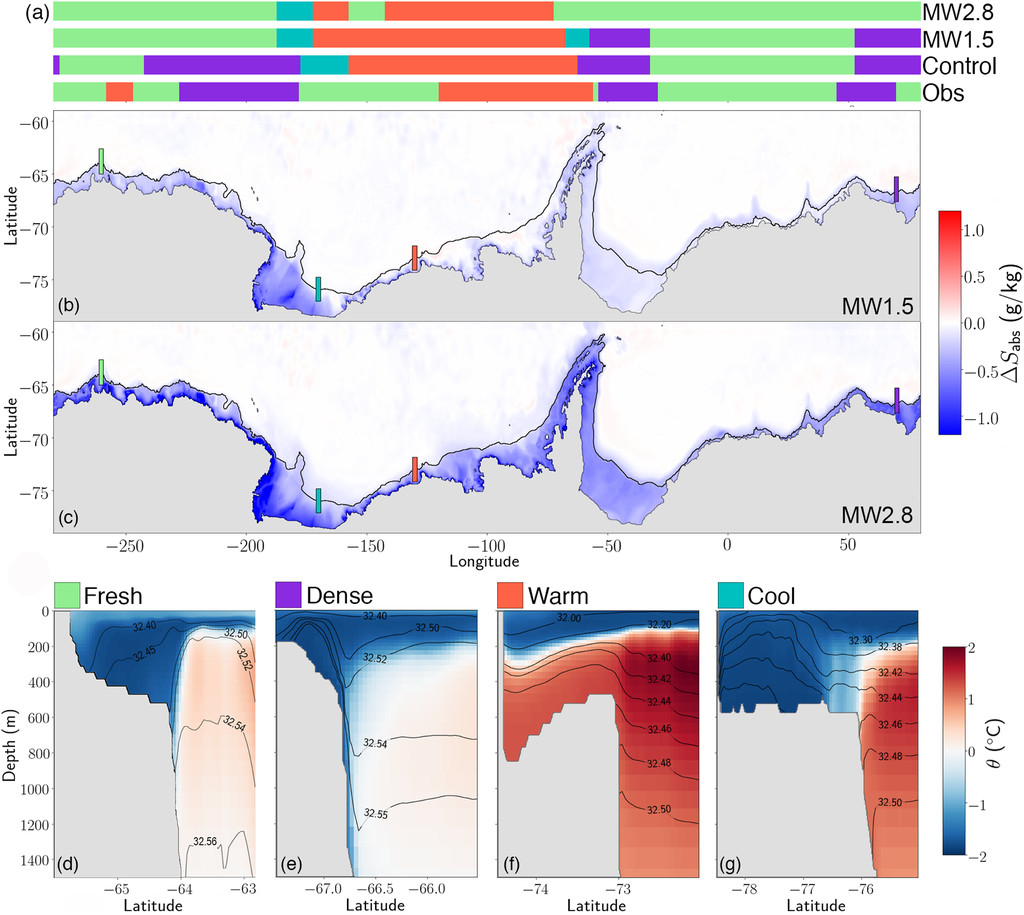


In [ ]:
import gsw

### 135 W: Warm regime

In [ ]:
cont_135W = cont.sel(xh='-135',method='nearest').mean('time')
melt_135W = melt.sel(xh='-135',method='nearest').mean('time')
cont_135W

In [ ]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_135W['z_l'], cont_135W['yh'])
p_melt = gsw.p_from_z(-melt_135W['z_l'], melt_135W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_135W['so'], p_cont, cont_135W['xh'], cont_135W['yh'])
SA_melt =  gsw.SA_from_SP(melt_135W['so'], p_melt, melt_135W['xh'], melt_135W['yh'])

# Calculating conservative temperature
temp_135W_C = gsw.CT_from_pt(SA_cont,cont_135W['thetao'])
temp_135W_M = gsw.CT_from_pt(SA_melt,melt_135W['thetao'])

# Calculating potential density rho_1 
rho1_135W_C = gsw.sigma1(SA_cont, temp_135W_C)
rho1_135W_M = gsw.sigma1(SA_melt, temp_135W_M)

In [ ]:
temp_135W_anom = temp_135W_M - temp_135W_C
temp_135W_anom.load()

In [ ]:
# To fix the label issues
temp_135W_anom = xr.DataArray(temp_135W_anom, dims=cont_135W['thetao'].dims, coords=cont_135W['thetao'].coords)
temp_135W_anom.attrs['units'] = '°C'
temp_135W_anom.name = 'CT'

rho1_135W_C.attrs["units"] = "kg m^-3"
rho1_135W_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_135W_M.attrs["units"] = "kg m^-3"
rho1_135W_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [ ]:
temp_135W_anom_new = temp_135W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-74.7,-72))
temp_135W_anom_new = temp_135W_anom_new.load()

In [ ]:
rho1_135W_C_new = rho1_135W_C.sel(z_l=slice(0,1500)).sel(yh=slice(-74.7,-72))
rho1_135W_M_new = rho1_135W_M.sel(z_l=slice(0,1500)).sel(yh=slice(-74.7,-72))

In [ ]:
# Plot your temperature anomaly
temp_135W_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.2,32.3,32.4,32.45,32.5]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_135W_M_new['yh'],  
    rho1_135W_M_new['z_l'], 
    rho1_135W_M_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_135W_C_new['yh'],  
    rho1_135W_C_new['z_l'], 
    rho1_135W_C_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle='--', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")


# Add title
plt.title("Pan005 temperature anomaly at 135°W with isopycnals")

plt.show()

### 170 W: Cool regime

In [19]:
cont_170W = cont.sel(xh='-170',method='nearest').mean('time')
melt_170W = melt.sel(xh='-170',method='nearest').mean('time')
cont_170W

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B -170.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [20]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_170W['z_l'], cont_170W['yh'])
p_melt = gsw.p_from_z(-melt_170W['z_l'], melt_170W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_170W['so'], p_cont, cont_170W['xh'], cont_170W['yh'])
SA_melt =  gsw.SA_from_SP(melt_170W['so'], p_melt, melt_170W['xh'], melt_170W['yh'])

# Calculating conservative temperature
temp_170W_C = gsw.CT_from_pt(SA_cont,cont_170W['thetao'])
temp_170W_M = gsw.CT_from_pt(SA_melt,melt_170W['thetao'])

# Calculating potential density rho_1 
rho1_170W_C = gsw.sigma1(SA_cont, temp_170W_C)
rho1_170W_M = gsw.sigma1(SA_melt, temp_170W_M)

In [21]:
temp_170W_anom = temp_170W_M - temp_170W_C
temp_170W_anom = temp_170W_anom.load()

In [22]:
# To fix the label issues
temp_170W_anom.attrs['units'] = '°C'
temp_170W_anom.name = 'CT'

rho1_170W_C.attrs["units"] = "kg m^-3"
rho1_170W_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_170W_M.attrs["units"] = "kg m^-3"
rho1_170W_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [23]:
temp_170W_anom_new = temp_170W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-78.5,-74.5))
temp_170W_anom_new = temp_170W_anom_new.load()

In [24]:
rho1_170W_C_new = rho1_170W_C.sel(z_l=slice(0,1500)).sel(yh=slice(-78.5,-74.5))
rho1_170W_M_new = rho1_170W_M.sel(z_l=slice(0,1500)).sel(yh=slice(-78.5,-74.5))

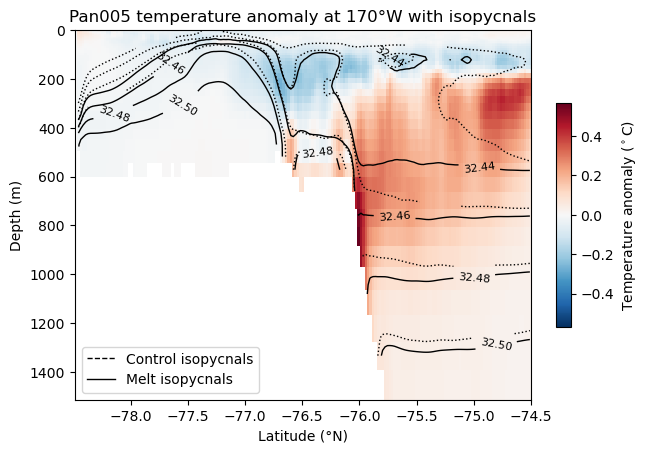

In [46]:
# Plot your temperature anomaly
temp_170W_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.44,32.46, 32.48,32.50]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_170W_M_new['yh'],  
    rho1_170W_M_new['z_l'], 
    rho1_170W_M_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_170W_C_new['yh'],  
    rho1_170W_C_new['z_l'], 
    rho1_170W_C_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle='--', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")


# Add title
plt.title("Pan005 temperature anomaly at 170°W with isopycnals")

plt.show()

### 260W: Fresh regime

In [26]:
cont_260W = cont.sel(xh='-260',method='nearest').mean('time')
melt_260W = melt.sel(xh='-260',method='nearest').mean('time')
cont_260W

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B -260.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [27]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_260W['z_l'], cont_260W['yh'])
p_melt = gsw.p_from_z(-melt_260W['z_l'], melt_260W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_260W['so'], p_cont, cont_260W['xh'], cont_260W['yh'])
SA_melt =  gsw.SA_from_SP(melt_260W['so'], p_melt, melt_260W['xh'], melt_260W['yh'])

# Calculating conservative temperature
temp_260W_C = gsw.CT_from_pt(SA_cont,cont_260W['thetao'])
temp_260W_M = gsw.CT_from_pt(SA_melt,melt_260W['thetao'])

# Calculating potential density rho_1 
rho1_260W_C = gsw.sigma1(SA_cont, temp_260W_C)
rho1_260W_M = gsw.sigma1(SA_melt, temp_260W_M)

In [28]:
temp_260W_anom = temp_260W_M - temp_260W_C
temp_260W_anom = temp_260W_anom.load()

In [29]:
# To fix the label issues
temp_260W_anom.attrs['units'] = '°C'
temp_260W_anom.name = 'CT'

rho1_260W_C.attrs["units"] = "kg m^-3"
rho1_260W_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_260W_M.attrs["units"] = "kg m^-3"
rho1_260W_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [30]:
temp_260W_anom_new = temp_260W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-66,-62.5))
temp_260W_anom_new = temp_260W_anom_new.load()

In [31]:
rho1_260W_C_new = rho1_260W_C.sel(z_l=slice(0,1500)).sel(yh=slice(-66,-62.5))
rho1_260W_M_new = rho1_260W_M.sel(z_l=slice(0,1500)).sel(yh=slice(-66,-62.5))

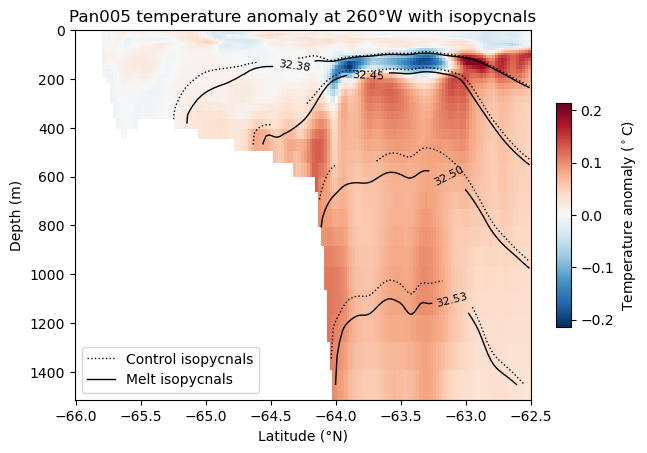

In [47]:
# Plot your temperature anomaly
temp_260W_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.38,32.45,32.50,32.53]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_260W_M_new['yh'],  
    rho1_260W_M_new['z_l'], 
    rho1_260W_M_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_260W_C_new['yh'],  
    rho1_260W_C_new['z_l'], 
    rho1_260W_C_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")


# Add title
plt.title("Pan005 temperature anomaly at 260°W with isopycnals")

plt.show()

### 70 E: Dense regime

In [33]:
cont_70E = cont.sel(xh='70',method='nearest').mean('time')
melt_70E = melt.sel(xh='70',method='nearest').mean('time')
cont_70E

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B 70.02
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [34]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_70E['z_l'], cont_70E['yh'])
p_melt = gsw.p_from_z(-melt_70E['z_l'], melt_70E['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_70E['so'], p_cont, cont_70E['xh'], cont_70E['yh'])
SA_melt =  gsw.SA_from_SP(melt_70E['so'], p_melt, melt_70E['xh'], melt_70E['yh'])

# Calculating conservative temperature
temp_70E_C = gsw.CT_from_pt(SA_cont,cont_70E['thetao'])
temp_70E_M = gsw.CT_from_pt(SA_melt,melt_70E['thetao'])

# Calculating potential density rho_1 
rho1_70E_C = gsw.sigma1(SA_cont, temp_70E_C)
rho1_70E_M = gsw.sigma1(SA_melt, temp_70E_M)

In [35]:
temp_70E_anom = temp_70E_M - temp_70E_C
temp_70E_anom = temp_70E_anom.load()

In [36]:
# To fix the label issues
temp_70E_anom.attrs['units'] = '°C'
temp_70E_anom.name = 'CT'

rho1_70E_C.attrs["units"] = "kg m^-3"
rho1_70E_C.attrs["long_name"] = "Potential density referenced to 1000 dbar"

rho1_70E_M.attrs["units"] = "kg m^-3"
rho1_70E_M.attrs["long_name"] = "Potential density referenced to 1000 dbar"

In [37]:
temp_70E_anom_new = temp_70E_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-69,-65))
temp_70E_anom_new = temp_70E_anom_new.load()

In [38]:
rho1_70E_C_new = rho1_70E_C.sel(z_l=slice(0,1500)).sel(yh=slice(-69,-65))
rho1_70E_M_new = rho1_70E_M.sel(z_l=slice(0,1500)).sel(yh=slice(-69,-65))

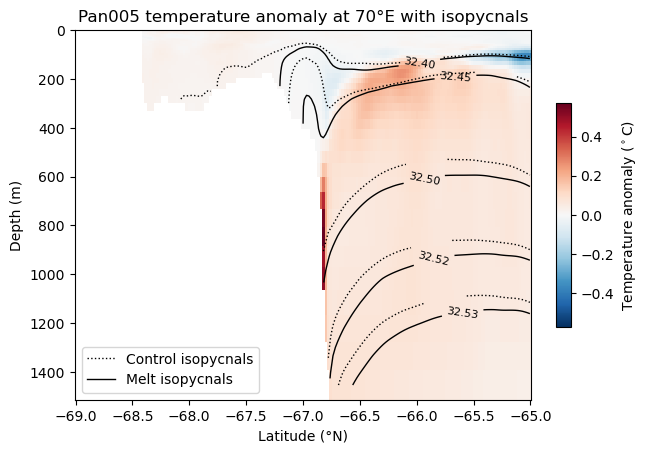

In [48]:
# Plot your temperature anomaly
temp_70E_anom_new.plot(
    vmin=-0.4, vmax=0.4,
    cbar_kwargs={
        "label": "Temperature anomaly ($^\circ$C)",
        "fraction": 0.03,
        "aspect": 15,
        "shrink": 0.7
    }
)

# Choose the density levels you want to show
density_levels = [32.40,32.45,32.50,32.52,32.53]

# Plot melt isopycnals
contour_melt = plt.contour(
    rho1_70E_M_new['yh'],  
    rho1_70E_M_new['z_l'], 
    rho1_70E_M_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linewidths=1
)
plt.clabel(contour_melt, inline=True, fontsize=8, fmt='%1.2f')

# Plot control density contours
contour_control = plt.contour(
    rho1_70E_C_new['yh'],  
    rho1_70E_C_new['z_l'], 
    rho1_70E_C_new.transpose('z_l', 'yh'),
    levels=density_levels,
    colors='k',
    linestyles=':',  # dotted lines
    linewidths=1
)
# Label control contours (invisible labels)
control_labels = plt.clabel(
    contour_control,
    fmt='%1.2f',
    inline=True,
    fontsize=8
)

# Set control labels color to white (invisible)
for txt in control_labels:
    txt.set_color('none')  # or use 'none' for fully transparent

plt.gca().invert_yaxis()


# Create custom legend handles
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')

plt.legend(handles=[control_handle, melt_handle], loc='lower left')

# Add axis labels
plt.xlabel("Latitude (°N)")
plt.ylabel("Depth (m)")

# Add title
plt.title("Pan005 temperature anomaly at 70°E with isopycnals")

plt.show()